# Voronoi - scipy

In [1]:
from random import randint, choice, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

## Load image as matrix

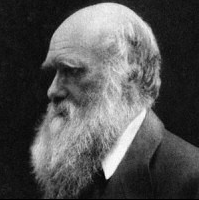

In [2]:
darwin = Image.open("darwin.png").convert("RGB")
darwin

In [3]:
img_dar = np.array(darwin)

In [32]:
def get_bounds_voronoi(nr_points, size, rgb_range = [0,255]):
    
    w_range = [1, size[0]]
    h_range = [1, size[1]]

    point = 3*[rgb_range] + [w_range, h_range]  # R; G, B, x, y
    bounds = nr_points*point

    return bounds

bounds_v = get_bounds_voronoi(nr_points=15, size = (199,200))

In [36]:
def popul_from_bounds_voronoi(bounds, popsize, nr_params = 5):
    
    population = []
    
    nr_points = len(bounds)//nr_params  # 5 - RGB and then X,Y
    
    for i in range(0, popsize):
        indv = []

        for j in range(nr_points):
            point = []
            for k in range(nr_params):
                point.append(randint(bounds[k][0],bounds[k][1]))
            indv.append(point)
        population.append(indv)
        
    return population

vor_pop = popul_from_bounds_voronoi(bounds=bounds_v, popsize=1)[0]

In [24]:
vor_pop

[[117, 1, 125, 8, 42],
 [108, 208, 184, 13, 42],
 [140, 46, 86, 162, 76],
 [219, 88, 120, 192, 68],
 [105, 226, 234, 132, 100],
 [121, 247, 91, 21, 133],
 [119, 130, 104, 65, 73],
 [6, 224, 127, 106, 130],
 [89, 15, 107, 151, 195],
 [147, 179, 203, 9, 164],
 [75, 94, 141, 58, 151],
 [71, 63, 171, 166, 177],
 [101, 102, 120, 126, 68],
 [15, 62, 122, 140, 116],
 [31, 120, 13, 126, 146]]

In [7]:
## NOTE this function copied from - stackoverflow - https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [8]:
# Generates image from Voronoi
    #size - image height and width
    #vor_data - list of voronoi data, in shape [[R,G,B,,X,Y],[..],..] 

def gen_image_voronoi2(size, vor_data):
    
    figure = plt.figure()
    plt.xlim(0, size[0])
    plt.ylim(0, size[1])
    
    plot = figure.add_subplot(111)

    points = [x[3:] for x in vor_data] # X,Y 
    colors = [x[:3] for x in vor_data] # [(R,G,B),..]
    
    # Calculate voronoi diagram based on points
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    for i, region in enumerate(regions):       
        new_color = tuple([x/255 for x in colors[i]])
        polygon = vertices[region]        
        plot.fill(*zip(*polygon), color=new_color, alpha=1)

    new_mat = fig2data(figure)
    new_mat = new_mat[:size[1], :size[0], :]  # Get correct size
    

    return new_mat

In [9]:
### Source: http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure 

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = (h,w,4)
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll (buf,3,axis=2)
    return buf

In [10]:
# Generates image from Voronoi
    #size - image height and width
    #vor_data - list of voronoi data, in shape [[R,G,B,,X,Y],[..],..] 

import math
    
def gen_image_voronoi(size, vor_data):

    points = [x[3:] for x in vor_data] # X,Y 
    colors = [x[:3] for x in vor_data] # [(R,G,B),..]
    
    # Calculate voronoi diagram based on points
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # Split into X and Y
    X = [coord[0] for coord in vertices]
    Y = [coord[1] for coord in vertices]
    # Get padding for X and Y
    pad_x = abs(math.floor(min(X)))
    pad_y = abs(math.floor(min(Y)))
    # Normalize the data, so it starts from 0
    X = np.array([X - min(X)])
    Y = np.array([Y - min(Y)])
    # Back to vertices
    vertices = np.concatenate((X.T,Y.T), axis=1)
    size_new = (math.ceil(max(X[0])), math.ceil(max(Y[0])))
    
    image = Image.new("RGB", size_new, (255,255,255,0)) 
    draw = ImageDraw.Draw(image, mode="RGBA")
    
    for i, region in enumerate(regions):       
        new_color = tuple(colors[i])
        polygon = vertices[region] 
        polygon = tuple(map(tuple, polygon))
        draw.polygon(polygon, fill= new_color)
        
    img_mat = np.array(image)

    del image
    del draw
    
    return img_mat[pad_y:size[1]+pad_y, pad_x:size[0]+pad_x]

(200, 200, 3)


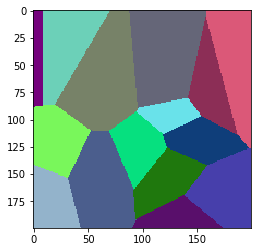

In [11]:
new_img = gen_image_voronoi((200,200), vor_pop)
print(new_img.shape)
size = (200,200)
plt.imshow(new_img)
plt.show()

In [12]:
# Cost function for using polygons
    # orig_mat - original image given as matrix
    # nr_points - number of points used
    # params - information about voronoi data in 1-D array (R,G,B,x,y)

def cost_voronoi(params, orig_mat, nr_points):
    
    vor_data = np.split(params, nr_points)
    size = tuple(reversed(orig_mat.shape[:2])) # W and H of image
    
    new_mat = gen_image_voronoi(size, vor_data)
        
    return square_error(orig_mat, new_mat)

In [13]:
def square_error(img1, img2):
    return np.sum(np.square(img1.astype("int64") - img2.astype("int64")))

In [14]:
def show_img(size, dna, nr):
    new_img = gen_image_voronoi(size, np.split(dna, nr))
    plt.imshow(new_img)
    plt.show()

In [22]:
def hill_voronoi(orig_img, nr_points, iter = 10, mut_rate = 0.05, mut_change = 0.05, mut_random = False):
    
    # Get params
    size = tuple(reversed(orig_img.shape[:2])) # W and H of image
    bounds = get_bounds_voronoi(nr_points=nr_points, size = size)
    
    # Init DNA
    dna = popul_from_bounds_voronoi(bounds=bounds, popsize=1)[0]  # Only one element in pop, take 1st
    dna = np.array(dna).flatten()
    #print(dna)
    
    print(len(dna))
    print(nr_points)
    cost_last = cost_voronoi(params=dna, nr_points=nr_points, orig_mat=orig_img)
        
    len_dna = len(dna)
    dna_last = dna
    dna_new = dna_last.copy()
    
    impr = 0
    
    for i in range(iter):    
        
        # Select randomly param to change and change it by mutation rate
        idx = randint(0, len_dna - 1)
        limits = bounds[idx]  # limits 
        
        if mut_random:
            # Random mutation
            dna_new[idx] = randint(limits[0], limits[1])
        else:
            #Mutate
            direction = choice([-1,1])  # Select randomly the direction
            dna_new[idx] = dna_last[idx] + direction*limits[1]*mut_rate
        
        # Quick limits check
        if dna_new[idx] > limits[1]:
            dna_new[idx] = limits[1]
        elif dna_new[idx] < limits[0]:
            dna_new[idx] = limits[0]
        
        # Calculate new cost
        cost_new = cost_voronoi(params=dna_new, nr_points=nr_points, orig_mat=orig_img)
        
        mut = random()
        
        # Compare costs
        if (mut < mut_change)  or (cost_new < cost_last):
            dna_last = dna_new.copy()
            cost_last = cost_new
            impr += 1
        else:
            dna_new = dna_last.copy()
            
        if i % 100 == 0:
            print("Iteration", i)
            print("improvements", impr)
            fit = cost_last/(255*255*3*size[0]*size[1])
            print("Fit: ", fit)
            show_img(size, dna_last, nr_points)
            
    show_img(size, dna_last, nr_points)
    return dna_last

150
30
Iteration 0
improvements 1
Fit:  0.217950358482


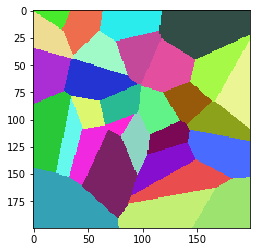

Iteration 100
improvements 40
Fit:  0.135847014259


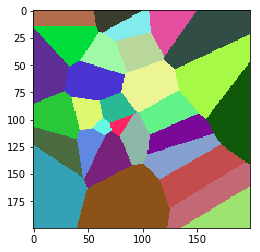

Iteration 200
improvements 71
Fit:  0.0944117091932


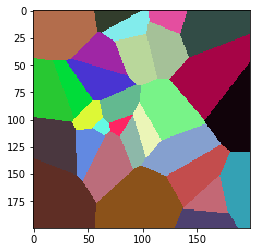

Iteration 300
improvements 97
Fit:  0.0746287670571


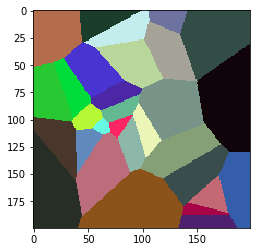

Iteration 400
improvements 122
Fit:  0.0551094237045


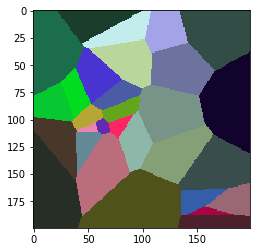

Iteration 500
improvements 143
Fit:  0.0463476902647


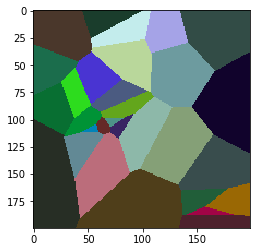

Iteration 600
improvements 159
Fit:  0.0438505972126


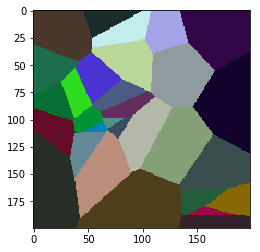

Iteration 700
improvements 176
Fit:  0.0382356526964


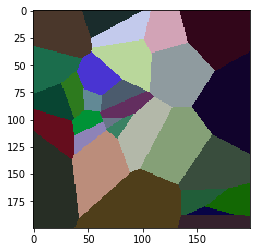

Iteration 800
improvements 191
Fit:  0.0361148287896


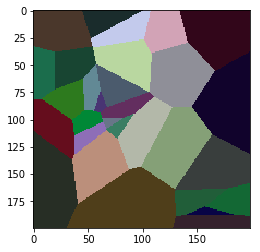

Iteration 900
improvements 203
Fit:  0.0337829235889


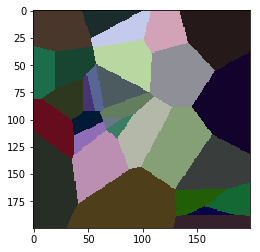

Iteration 1000
improvements 214
Fit:  0.0317297273243


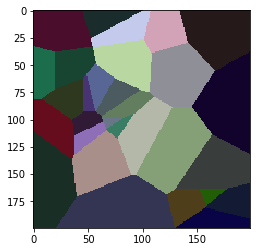

Iteration 1100
improvements 226
Fit:  0.0292541139634


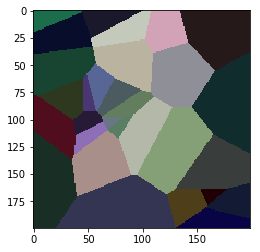

Iteration 1200
improvements 237
Fit:  0.0283289188477


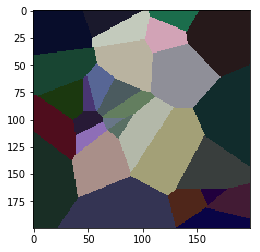

Iteration 1300
improvements 249
Fit:  0.0262072194884


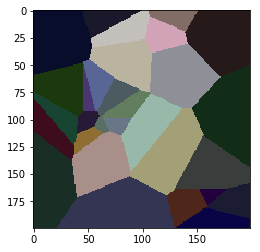

Iteration 1400
improvements 258
Fit:  0.0245131018414


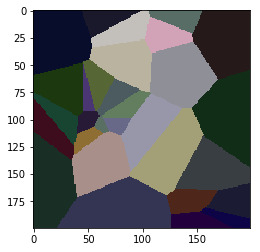

Iteration 1500
improvements 267
Fit:  0.0229445644215


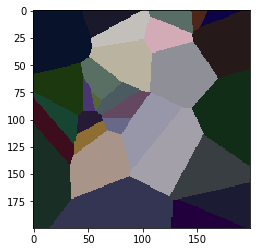

Iteration 1600
improvements 277
Fit:  0.0224823242188


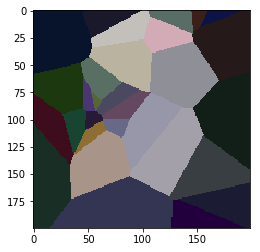

Iteration 1700
improvements 288
Fit:  0.0219349614921


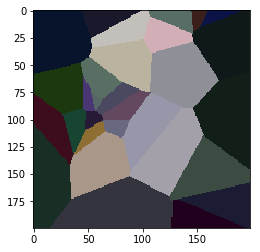

Iteration 1800
improvements 300
Fit:  0.0215948735089


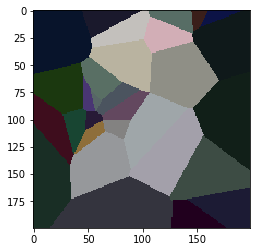

Iteration 1900
improvements 308
Fit:  0.0212955330285


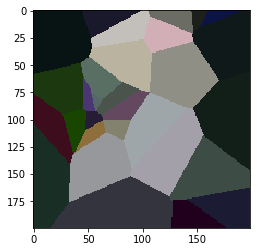

Iteration 2000
improvements 312
Fit:  0.0210720277023


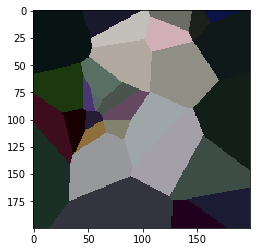

Iteration 2100
improvements 321
Fit:  0.0203061478094


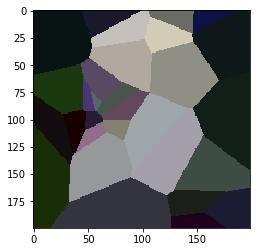

Iteration 2200
improvements 326
Fit:  0.0200827307111


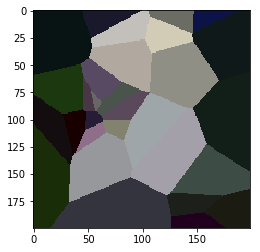

Iteration 2300
improvements 330
Fit:  0.019783900922


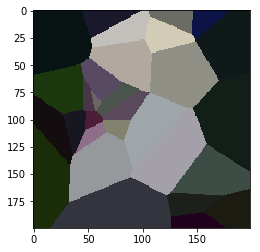

Iteration 2400
improvements 338
Fit:  0.0196443631717


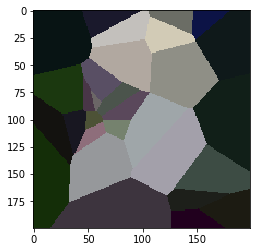

Iteration 2500
improvements 340
Fit:  0.0195514924359


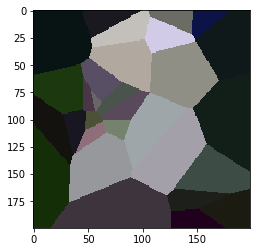

Iteration 2600
improvements 344
Fit:  0.0194034804292


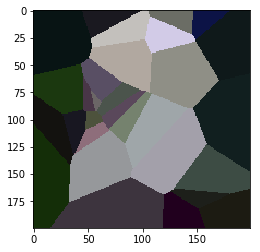

Iteration 2700
improvements 350
Fit:  0.0192545320477


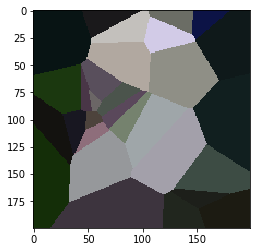

Iteration 2800
improvements 353
Fit:  0.0191119399381


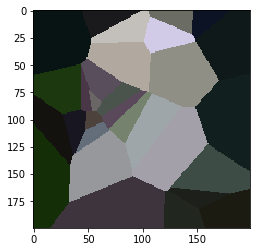

Iteration 2900
improvements 360
Fit:  0.018975685682


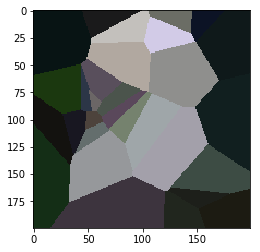

Iteration 3000
improvements 364
Fit:  0.0187102082243


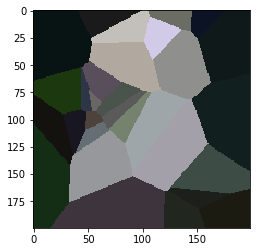

Iteration 3100
improvements 368
Fit:  0.0184752847925


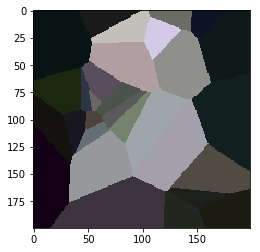

Iteration 3200
improvements 372
Fit:  0.018213246548


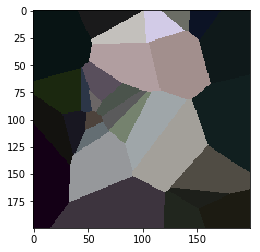

Iteration 3300
improvements 378
Fit:  0.0180862303315


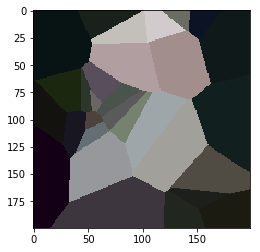

Iteration 3400
improvements 379
Fit:  0.0180822117766


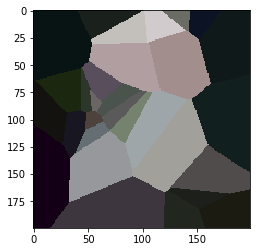

Iteration 3500
improvements 381
Fit:  0.0179800812341


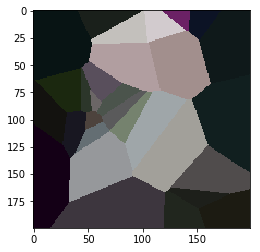

Iteration 3600
improvements 385
Fit:  0.0179380651817


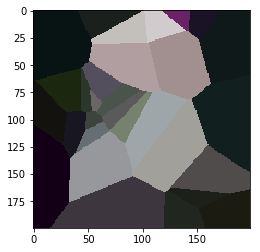

Iteration 3700
improvements 390
Fit:  0.0178170712592


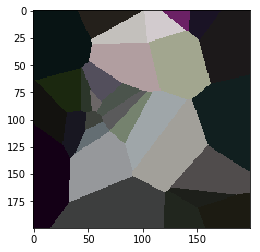

Iteration 3800
improvements 393
Fit:  0.0177580201404


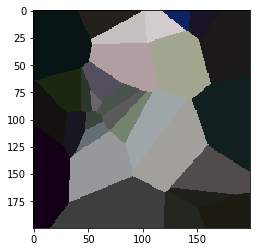

Iteration 3900
improvements 398
Fit:  0.0176649696


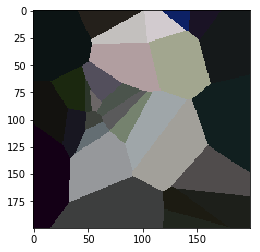

Iteration 4000
improvements 402
Fit:  0.0176230249028


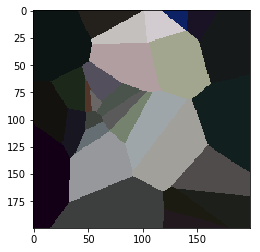

Iteration 4100
improvements 406
Fit:  0.0174775058169


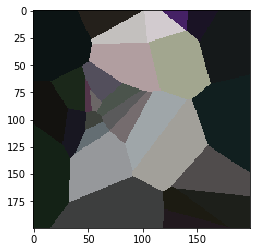

Iteration 4200
improvements 409
Fit:  0.0174652212749


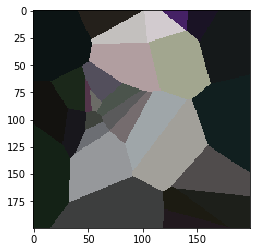

Iteration 4300
improvements 412
Fit:  0.0173936456601


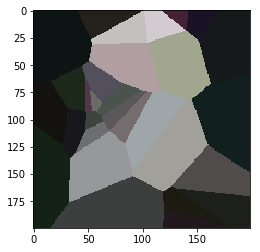

Iteration 4400
improvements 416
Fit:  0.0173813557084


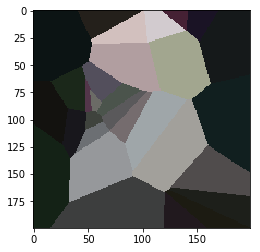

Iteration 4500
improvements 419
Fit:  0.0172979464798


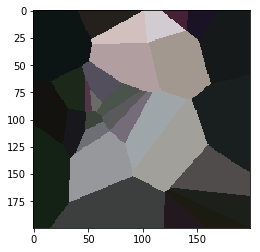

Iteration 4600
improvements 422
Fit:  0.0172907533953


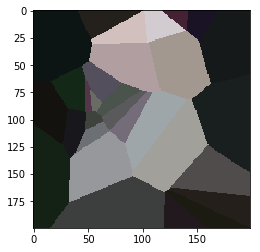

Iteration 4700
improvements 426
Fit:  0.0172323238646


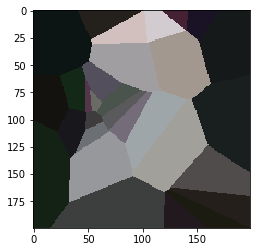

KeyboardInterrupt: 

In [40]:
hill_voronoi(img_dar, nr_points = 30, iter = 10000, mut_random=True, mut_change=-1)

225
45
Iteration 0
improvements 1
Fit:  0.163591876594


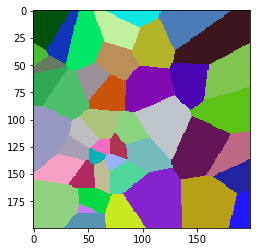

Iteration 100
improvements 35
Fit:  0.134039799794


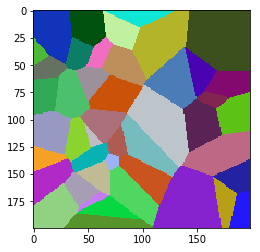

Iteration 200
improvements 67
Fit:  0.0972526690868


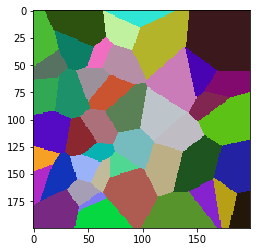

Iteration 300
improvements 95
Fit:  0.0749334949771


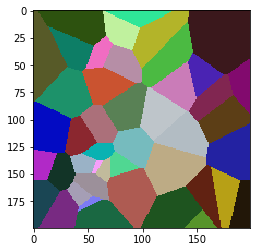

In [ ]:
hill_voronoi(img_dar, nr_points = 45, iter = 10000, mut_random=True, mut_change=-1)

In [ ]:
darwin